# Concrete ML in action

In this notebook, we show you how to use build-in models using Concrete ML libraries.

##### Import required libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from concrete.ml.torch.compile import compile_brevitas_qat_model
from brevitas.nn import QuantLinear, QuantReLU
from utils_demo import CustomDataset, plot_data, plot_datasets, plot_decision_boundary

%matplotlib inline

### Generate synthetic data-set

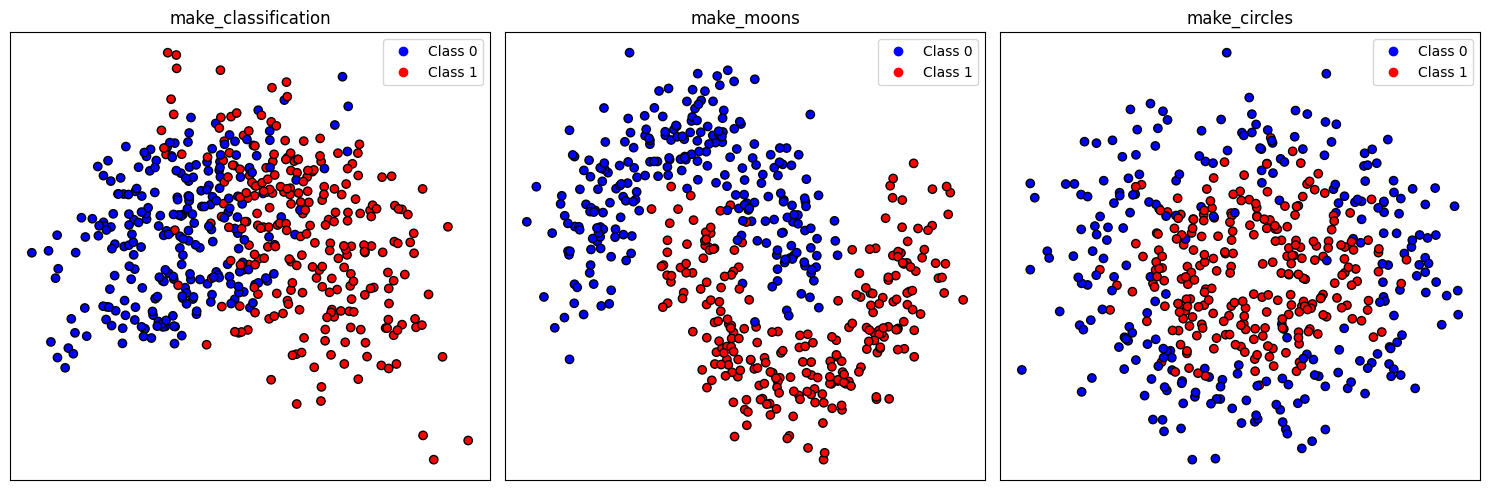

In [2]:
# Dataset1 has been generated through make_classification 
# Dataset2 has been generated through make_moons
# dataset3 has been generated through make circles

dataset1, dataset2, dataset3 = plot_datasets()

## 1. Linear models

In what follows, we compare the execution time and performanc!e of the standard logistic regression of scikit-learn with the one of Concrete ML.

We choose the data-set that has been generated through make_classification to solve this linear problem.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset1[0], dataset1[1], test_size=0.2, random_state=42)

# Shape
X_train.shape, X_test.shape

((400, 2), (100, 2))

### With scikit-learn

Scikit-learn accuracy: 84.00%


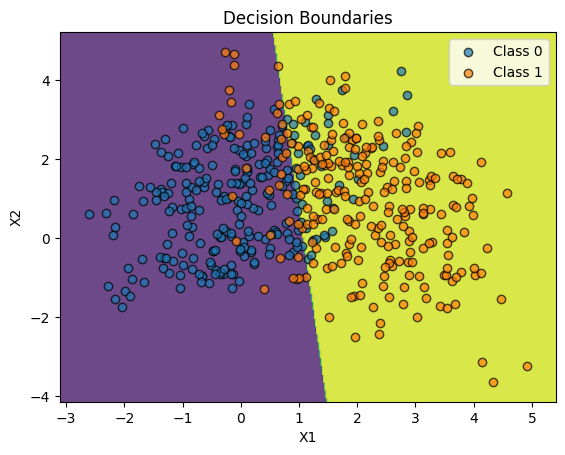

In [4]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# Instanciate the model
sklearn_logit = SklearnLogisticRegression()

# Fit the model
sklearn_logit.fit(X_train, y_train)

# Predict
y_pred = sklearn_logit.predict(X_test)

# Evaluate the model
sklearn_accuracy = accuracy_score(y_test, y_pred)

print(f"Scikit-learn accuracy: {sklearn_accuracy:.2%}")

# Plot decision boundary
plot_decision_boundary(sklearn_logit, dataset1)

### With Concrete ML

Execution time in fhe: 0.0001 seconds per sample
Concrete ML accuracy: 82.00% VS Scikit-learn accuracy: 84.00%


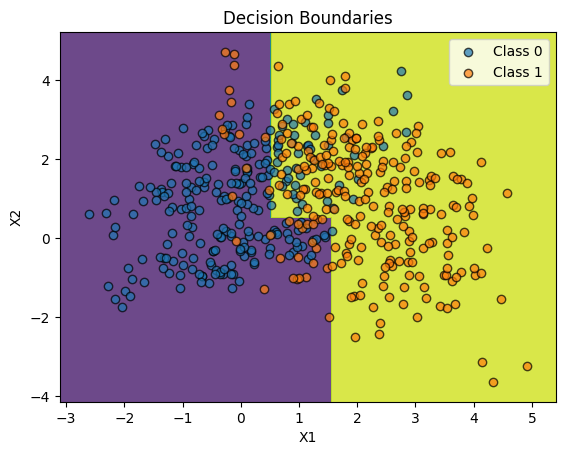

In [5]:
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

# 1. Instaciate the model
# ConcreteLogisticRegression has the same attributes and methods as SklearnLogisticRegression
# The additional hyper-parameter is `n_bits` used for the quantization
# The quantization is done through PTQ approach
concrete_logit = ConcreteLogisticRegression(n_bits=3)

# 2. The `fit` method is the same as the scikit-learn one 
concrete_logit.fit(X_train, y_train)

# 3. compilation 
# It allows you to:
# - create the operational graph (in our jargon we call it a circuit)
# - Generate he crypto parameters
# - check if the circuit is if the circuit is compliant with the FHE requirements
#       - bit-width inside the circuit must be less than 16-bits
#       - all intermediate values are properly quantized 

# You need to provide an exhaustive set of data to evaluate the maximum integer bit-width within the graph
# which is needed during FHE computations before running any predictions.
# You can either provide the entire trained data-set or a smaller but representative subset.
fhe_circuit = concrete_logit.compile(X_train)

# Generate the keys
fhe_circuit.client.keygen(force=False)

# FHE inference
time_begin = time.time()
y_pred_fhe = concrete_logit.predict(X_test, fhe="execute")
print(f"Execution time in fhe: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

## Concrete ML vs scikit-learn:
print(
    f"Concrete ML accuracy: {fhe_accuracy:.2%} VS "
    f"Scikit-learn accuracy: {sklearn_accuracy:.2%}"
)

plot_decision_boundary(concrete_logit, dataset1)

Let's check the effect of the quantization on the decision boundary with n_bits = 2

## Tree-based models

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset2[0], dataset2[1], test_size=0.2, random_state=42)

# Shape
X_train.shape, X_test.shape

((400, 2), (100, 2))

### With scikit-learn

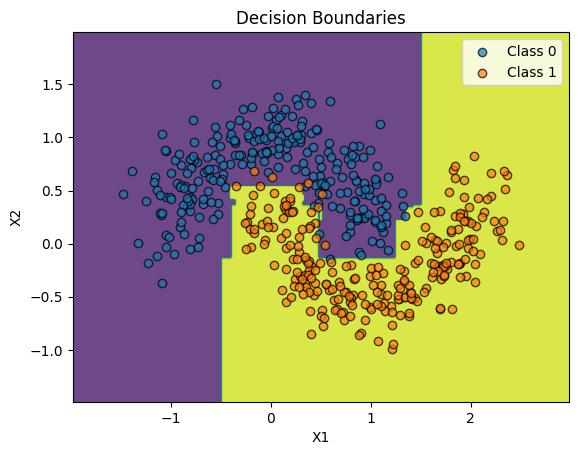

Scikit-learn accuracy: 97.00%


In [8]:
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

sklearn_trees = SklearnXGBClassifier(random_state=727)

sklearn_trees.fit(X_train, y_train)

y_pred = sklearn_trees.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, y_pred)

plot_decision_boundary(sklearn_trees, dataset2)

print(f"Scikit-learn accuracy: {sklearn_accuracy:.2%}")


Compilation time: 0.40 s

Execution time in FHE: 0.6719 seconds per sample

Concrete ML accuracy: 93.00% VS Scikit-learn accuracy: 97.00%


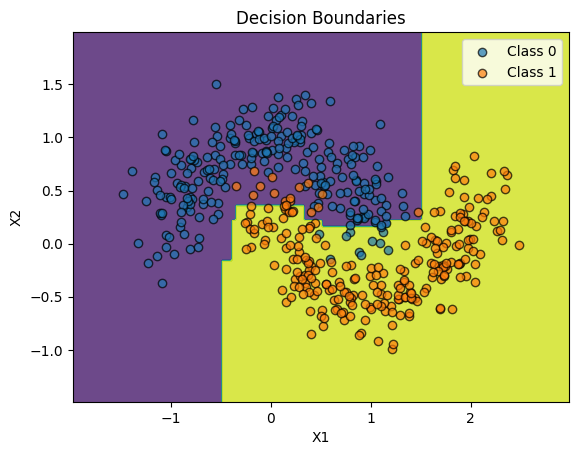

In [14]:
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

# Step 1: For build-in models, we use a Post Taining Quantization
concrete_trees = ConcreteXGBClassifier(n_bits=8)

concrete_trees.fit(X_train, y_train)

time_begin = time.time()
fhe_circuit = concrete_trees.compile(X_train)
print(f"Compilation time: {(time.time() - time_begin):.2f} s\n")

# generate the keys
fhe_circuit.client.keygen(force=False)

# Real FHE mode
time_begin = time.time()
y_pred_fhe = concrete_trees.predict(X_test[0, None], fhe="execute")
print(f"Execution time in FHE: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample\n")

y_pred_fhe = concrete_trees.predict(X_test, fhe="simulate")
fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

print(
    f"Concrete ML accuracy: {fhe_accuracy:.2%} VS "
    f"Scikit-learn accuracy: {sklearn_accuracy:.2%}"
)
plot_decision_boundary(concrete_trees, dataset2)

Concrete ML accuracy: 90.00% VS Scikit-learn accuracy: 97.00%


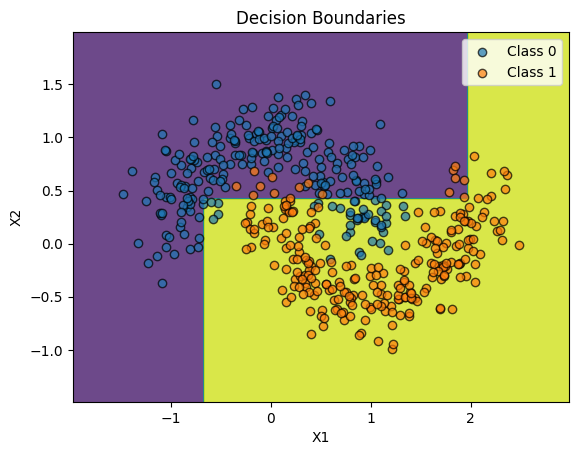

In [15]:
concrete_trees = ConcreteXGBClassifier(n_bits=2)
concrete_trees.fit(X_train, y_train)
fhe_circuit = concrete_trees.compile(X_train)
fhe_circuit.client.keygen(force=False)
y_pred_fhe = concrete_trees.predict(X_test, fhe="simulate")
fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

print(
    f"Concrete ML accuracy: {fhe_accuracy:.2%} VS "
    f"Scikit-learn accuracy: {sklearn_accuracy:.2%}"
)
plot_decision_boundary(concrete_trees, dataset2)

In [39]:
from sklearn.neural_network import MLPClassifier
from concrete.ml.sklearn import NeuralNetClassifier

params_neural_net = {
    "module__n_hidden_neurons_multiplier": 100,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.ReLU,
    "module__n_w_bits": 8,
    "module__n_a_bits": 8,
    "module__n_accum_bits": 32,
}

sklearn_nn = NeuralNetClassifier(batch_size=32, **{**params_neural_net, **concrete_params})

concrete_nn.fit(X_train, y_train)

concrete_nn.compile(X_train)

y_pred_fhe = concrete_nn.predict(X_test, fhe="simulate")

fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

fhe_accuracy

0.94

In [35]:
params_neural_net = {
    "hidden_layer_sizes": (100, 2),
    "activation": "relu",

}

sklearn_nn = MLPClassifier(batch_size=32, **params_neural_net)

sklearn_nn.fit(X_train, y_train)

y_pred = sklearn_nn.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, y_pred)

sklearn_accuracy

0.98

## Custom neural network

In [25]:
from utils_demo import TorchCustomModel

param = {
    "output_size": 2,
    "batch_size": 128,
    "training": "fp32",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/",
    "seed": 727,
    "lr": 0.021,
    "epochs": 50,
    "gamma": 0.1,
    "milestones": [10000000000]
}


class TorchCustomModel(nn.Module):
    """A small network with Brevitas, trained on make_classification."""

    def __init__(self, input_shape, hidden_shape, output_shape):
        """Torch Model.

        Args:
            input_shape (int): Input size
            output_shape (int): Output size
            hidden_shape (int): Hidden size
        """
        super().__init__()
        self.linear1 = nn.Linear(input_shape, hidden_shape)
        self.linear2 = nn.Linear(hidden_shape, hidden_shape)

        self.linear3 = nn.Linear(hidden_shape, output_shape)
    def forward(self, x):
        """Forward pass.

        Args:
            x (torch.tensor): The input of the model.

        Returns:
            torch.tensor: Output of the network.
        """
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

qnn= TorchCustomModel(2, 70, 2)

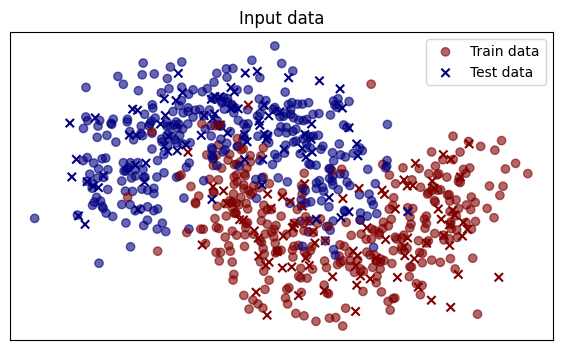

In [32]:
X, y = make_moons(n_samples=800, noise=0.3, random_state=0)
#X, y = make_circles(n_samples=800, noise=0.2, factor=0.5, random_state=1)
   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
plot_data(X_train, X_test, y_train, y_test, title="Input data")


In [33]:
# Convert to a data_loader
train_dataset = CustomDataset(X_train, y_train)
test_dataset  = CustomDataset(X_test, y_train)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [34]:
qnn = train(qnn, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 1.8519 VS Test loss = 4.0279 - Accuracy train: 0.7266 VS Accuracy test: 0.5188
Epoch  1: Train loss = 0.2618 VS Test loss = 3.1128 - Accuracy train: 0.8875 VS Accuracy test: 0.5563
Epoch  2: Train loss = 0.2284 VS Test loss = 4.3457 - Accuracy train: 0.9062 VS Accuracy test: 0.5375
Epoch  3: Train loss = 0.2303 VS Test loss = 4.7870 - Accuracy train: 0.9078 VS Accuracy test: 0.5250
Epoch  4: Train loss = 0.2205 VS Test loss = 3.5228 - Accuracy train: 0.9078 VS Accuracy test: 0.5437
Epoch  5: Train loss = 0.2077 VS Test loss = 3.5422 - Accuracy train: 0.9141 VS Accuracy test: 0.5375
Epoch  6: Train loss = 0.1984 VS Test loss = 4.1209 - Accuracy train: 0.9187 VS Accuracy test: 0.5062
Epoch  7: Train loss = 0.1943 VS Test loss = 3.6321 - Accuracy train: 0.9156 VS Accuracy test: 0.5125
Epoch  8: Train loss = 0.1910 VS Test loss = 4.4487 - Accuracy train: 0.9219 VS Accuracy test: 0.4938
Epoch  9: Train loss = 0.1956 VS Test loss = 4.0278 - Accuracy train: 0.9297 VS Ac

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils_demo import CustomNeuralNet
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_circles(n_samples=1000, noise=0.1, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Set the hyperparameters
input_size = 2
hidden_size = 64
num_classes = 2
learning_rate = 0.001
num_epochs = 400

# Initialize the neural network
model = CustomNeuralNet(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Evaluation
with torch.no_grad():
    # Switch to evaluation mode
    model.eval()

    # Forward pass on the testing set
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted)
    print("Accuracy:", accuracy)


Epoch [10/400], Loss: 0.6947702169418335
Epoch [20/400], Loss: 0.6869655847549438
Epoch [30/400], Loss: 0.6795026659965515
Epoch [40/400], Loss: 0.6719582080841064
Epoch [50/400], Loss: 0.6642060875892639
Epoch [60/400], Loss: 0.6562325954437256
Epoch [70/400], Loss: 0.6478960514068604
Epoch [80/400], Loss: 0.6392111778259277
Epoch [90/400], Loss: 0.6302022337913513
Epoch [100/400], Loss: 0.620921790599823
Epoch [110/400], Loss: 0.6113514304161072
Epoch [120/400], Loss: 0.6016038656234741
Epoch [130/400], Loss: 0.5916598439216614
Epoch [140/400], Loss: 0.5815995335578918
Epoch [150/400], Loss: 0.5715272426605225
Epoch [160/400], Loss: 0.5613809823989868
Epoch [170/400], Loss: 0.5512633323669434
Epoch [180/400], Loss: 0.5411556363105774
Epoch [190/400], Loss: 0.5311540365219116
Epoch [200/400], Loss: 0.5213755965232849
Epoch [210/400], Loss: 0.5118392705917358
Epoch [220/400], Loss: 0.5025360584259033
Epoch [230/400], Loss: 0.49351832270622253
Epoch [240/400], Loss: 0.484747052192688
Ep

In [17]:
# Evaluation
with torch.no_grad():
    # Switch to evaluation mode
    model.eval()

    # Forward pass on the testing set
    outputs = model(X_train)
    _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    accuracy = accuracy_score(y_train, predicted)
    print("Accuracy:", accuracy)


Accuracy: 0.8625


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # Generate a grid of points within the input range
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02  # step size for the meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Convert the grid points to tensors
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Make predictions for each point in the grid
    Z = model.predict(grid_tensor)
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)

    # Create a contour plot
    plt.contourf(xx, yy, Z, alpha=0.8)

    # Plot the training samples
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Boundaries')

    plt.show()


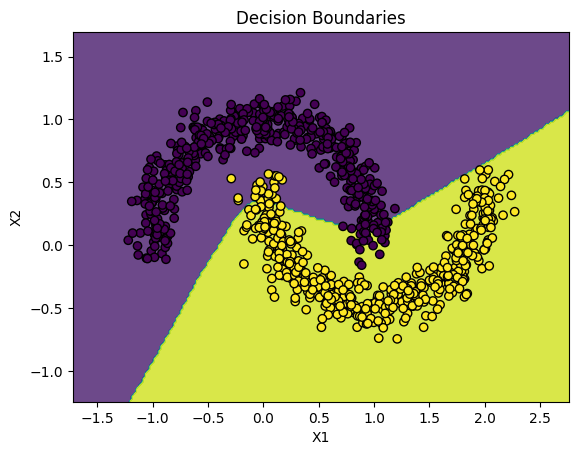

In [6]:
plot_decision_boundary(model, X, y)